In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install infercnvpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import scanpy as sc
train_path = '/content/drive/MyDrive/stemcell/final_project/PBMC_simulated_cnas_041025.h5ad'

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/stemcell/final_project/final_project')

In [5]:
import scancnv
from scancnv.infer import infer_cnv_and_annotate
from scancnv.infer import annotate_cnv
from scancnv.filter_genes import filter_genes_by_chromosome
from scancnv.annotate import annotate_normal_cells
from scancnv.subset import subset_shared_genes
from scancnv.assess import assess_cnv

In [22]:
def transfer_gene_positions(adata, adata_train):
    """
    Copy the ['chromosome', 'start', 'end'] columns from adata_train.var to adata.var.

    Parameters
    ----------
    adata : AnnData
        The target object to which positional information will be written into `.var`.
    adata_train : AnnData
        The source object whose `.var` must contain the columns ['chromosome', 'start', 'end'],
        and whose index (var_names) should be gene names.

    Returns
    -------
    None (The operation modifies `adata` in place)
    """
    # 1. Extract source positional information
    gene_pos = adata_train.var[['chromosome', 'start', 'end']].copy()

    # 2. Check for uniqueness
    if not adata_train.var_names.is_unique:
        raise ValueError("Duplicate gene names found in adata_train.var_names; cannot match safely.")
    if not adata.var_names.is_unique:
        # You could also choose to call adata.var_names_make_unique() beforehand
        raise ValueError("Duplicate gene names found in adata.var_names; please deduplicate or append suffixes.")

    # 3. Reindex according to adata.var_names; missing entries will become NaN
    gene_pos = gene_pos.reindex(adata.var_names)

    # 4. Write back to adata.var
    adata.var[['chromosome', 'start', 'end']] = gene_pos

    # (Optional) Print result for confirmation
    print(f"Transferred positions for {gene_pos.dropna().shape[0]} / {adata.n_vars} genes.")

# — Example usage —
# Assuming `adata_train` is already loaded, and `adata` is the target object
# transfer_gene_positions(adata, adata_train)

# 1. PSC-derived kidney organoids

In [6]:
# Assume your data is located in the ./GSE263152/ directory
adata = sc.read_10x_mtx(
    '/content/drive/MyDrive/stemcell/final_project/test_dataset/GSM7993675',  # Directory containing matrix.mtx.gz, barcodes.tsv.gz, and features.tsv.gz
    var_names='gene_symbols',
    cache=True
)

# Save as .h5ad format
adata.write('/content/drive/MyDrive/stemcell/final_project/test_dataset/GSM7993675/GSE263152.h5ad')

In [21]:
adata = sc.read_h5ad('/content/drive/MyDrive/stemcell/final_project/test_dataset/GSM7993675/GSE263152.h5ad')

/content/drive/MyDrive/stemcell/final_project/final_project/scancnv/infer.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, grp in gene_pos_df.groupby("chromosome"):


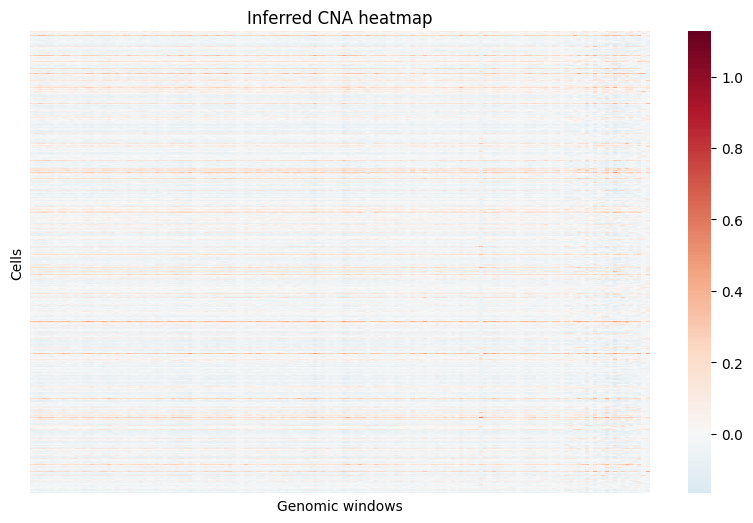

In [8]:
train_path = '/content/drive/MyDrive/stemcell/final_project/PBMC_simulated_cnas_041025.h5ad'
adata_train = sc.read_h5ad(train_path)
adata_train = filter_genes_by_chromosome(adata_train)
gene_pos_df = adata_train.var[['chromosome', 'start', 'end']]

# Keep only genes that have positional information in gene_pos_df
# Take the intersection
shared_genes = adata.var_names.intersection(gene_pos_df.index)

# Keep only these genes in both adata and gene_pos_df
adata = adata[:, shared_genes].copy()
gene_pos_df = gene_pos_df.loc[shared_genes].copy()

# Assume `adata` is already loaded and adata.obs['celltype'] contains annotations
# Assume `gene_pos_df` is ready with index matching adata.var_names and contains chromosome/start/end
adata.obs["cell_type"] = ["B cell"] * adata.n_obs

cnv_scores = infer_cnv_and_annotate(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=150,
    thresh_del=-0.2,
    thresh_half=-0.15,
    thresh_gain=0.7
)

# `cnv_scores` is a CNA score matrix (cells × windows)
# You can visualize it with seaborn or matplotlib:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    cnv_scores,
    cmap="RdBu_r",
    center=0,
    yticklabels=False,
    xticklabels=False
)
plt.xlabel("Genomic windows")
plt.ylabel("Cells")
plt.title("Inferred CNA heatmap")
plt.show()

In [10]:
print(adata.obs['annotated_cnvs'].value_counts())

annotated_cnvs
                                                                                         17818
X:103075810-108091549 (CN 1)                                                               764
11:62832342-67398410 (CN 4), X:74582976-93673578 (CN 4), X:103075810-108091549 (CN 4)        8
Name: count, dtype: int64


In [39]:
X_cnv = adata.obsm['X_cnv']
print(adata.uns)

OrderedDict([('cnv', {'chr_pos': {'chr1': np.int64(0), 'chr2': np.int64(183), 'chr3': np.int64(300), 'chr4': np.int64(395), 'chr5': np.int64(453), 'chr6': np.int64(526), 'chr7': np.int64(606), 'chr8': np.int64(684), 'chr9': np.int64(742), 'chr10': np.int64(804), 'chr11': np.int64(863), 'chr12': np.int64(957), 'chr13': np.int64(1052), 'chr14': np.int64(1075), 'chr15': np.int64(1137), 'chr16': np.int64(1192), 'chr17': np.int64(1277), 'chr18': np.int64(1387), 'chr19': np.int64(1408), 'chr20': np.int64(1539), 'chr21': np.int64(1580), 'chr22': np.int64(1592)}})])


# 2.hESC -> endothelial

In [43]:
adata=sc.read_10x_h5('/content/drive/MyDrive/stemcell/final_project/test_dataset/GSM3814885_day0_filtered_gene_bc_matrices_h5.h5')

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/content/drive/MyDrive/stemcell/final_project/final_project/scancnv/infer.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, grp in gene_pos_df.groupby("chromosome"):


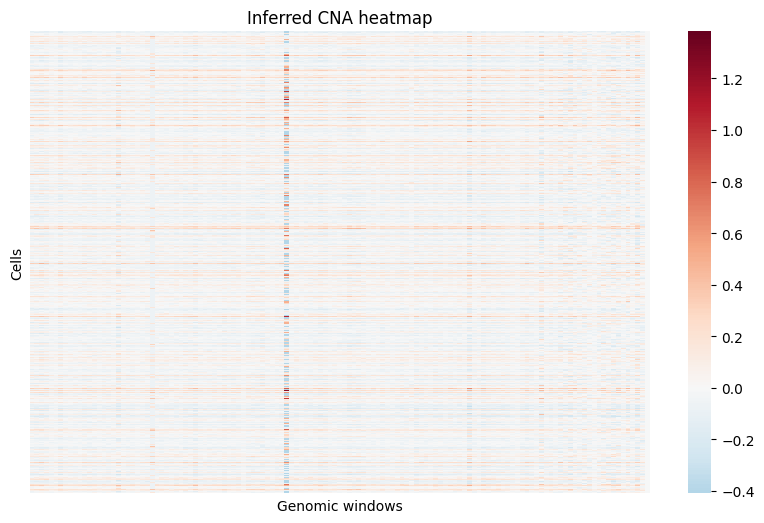

In [45]:
adata.var_names_make_unique()
gene_pos_df = adata_train.var[['chromosome', 'start', 'end']]

# Keep only genes that have positional information in gene_pos_df
# Take the intersection
shared_genes = adata.var_names.intersection(gene_pos_df.index)

# Retain only these genes in both adata and gene_pos_df
adata = adata[:, shared_genes].copy()
gene_pos_df = gene_pos_df.loc[shared_genes].copy()

# Assume `adata` is already loaded and adata.obs['celltype'] contains annotations
# Assume `gene_pos_df` is ready, with an index matching adata.var_names and columns: chromosome/start/end
adata.obs["cell_type"] = ["B cell"] * adata.n_obs

cnv_scores = infer_cnv_and_annotate(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=150,
    thresh_del=-0.2,
    thresh_half=-0.15,
    thresh_gain=0.7,
    min_annots=300,
    min_cells=300
)

# `cnv_scores` is a CNA score matrix (cells × windows)
# You can visualize it using seaborn or matplotlib:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    cnv_scores,
    cmap="RdBu_r",
    center=0,
    yticklabels=False,
    xticklabels=False
)
plt.xlabel("Genomic windows")
plt.ylabel("Cells")
plt.title("Inferred CNA heatmap")
plt.show()

In [19]:
print(adata.obs['annotated_cnvs'].value_counts())

annotated_cnvs
                                6658
9:137615326-137870016 (CN 0)    1112
21:46098112-46665685 (CN 1)      409
Name: count, dtype: int64


# 3.hESC to microglia

In [51]:
import scanpy as sc
adata = sc.read_csv('/content/drive/MyDrive/stemcell/final_project/test_dataset/GSM4143592_Day4_counts.csv.gz')

/content/drive/MyDrive/stemcell/final_project/final_project/scancnv/infer.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, grp in gene_pos_df.groupby("chromosome"):


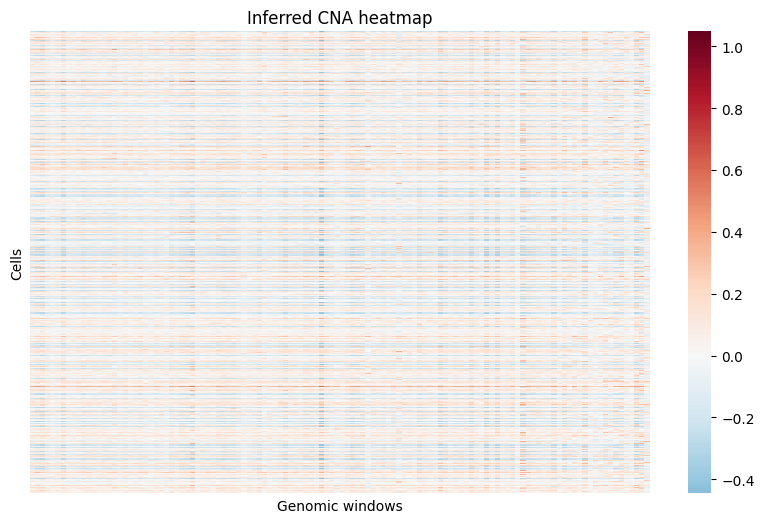

In [61]:
train_path = '/content/drive/MyDrive/stemcell/final_project/PBMC_simulated_cnas_041025.h5ad'
adata_train = sc.read_h5ad(train_path)
adata_train = filter_genes_by_chromosome(adata_train)
gene_pos_df = adata_train.var[['chromosome', 'start', 'end']]

# Keep only genes that have positional information in gene_pos_df
# Take the intersection
shared_genes = adata.var_names.intersection(gene_pos_df.index)

# Retain only these genes in both adata and gene_pos_df
adata = adata[:, shared_genes].copy()
gene_pos_df = gene_pos_df.loc[shared_genes].copy()

# Assume that adata is already loaded and adata.obs['celltype'] contains annotations
# Assume gene_pos_df is ready with an index that matches adata.var_names and contains columns: chromosome, start, and end
adata.obs["cell_type"] = ["B cell"] * adata.n_obs

cnv_scores = infer_cnv_and_annotate(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=150,
    thresh_del=-0.2,
    thresh_half=-0.15,
    thresh_gain=0.5,
    min_annots=30,
    min_cells=30
)

# `cnv_scores` is a CNA score matrix (cells × windows)
# You can visualize it using seaborn or matplotlib:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    cnv_scores,
    cmap="RdBu_r",
    center=0,
    yticklabels=False,
    xticklabels=False
)
plt.xlabel("Genomic windows")
plt.ylabel("Cells")
plt.title("Inferred CNA heatmap")
plt.show()

In [62]:
print(adata.obs['annotated_cnvs'].value_counts())

annotated_cnvs
                                5159
19:58345178-58573575 (CN 1)       54
X:154428633-156013017 (CN 1)      40
Name: count, dtype: int64
